In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import os

# 设置绘图风格和中文字体支持
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号



In [30]:
class DataEvaluator:
    def __init__(self, real_path, rule_path, gan_path, numerical_cols, target_col):
        """
        初始化评估器
        :param real_path: 真实数据路径
        :param rule_path: 规则生成数据路径
        :param gan_path: GAN生成数据路径
        :param numerical_cols: 需要分析的数值型列名列表
        :param target_col: 下游任务(预测)的目标列
        """
        self.data_dict = {
            "Real": pd.read_csv(real_path),
            "Rule": pd.read_csv(rule_path),
            "GAN": pd.read_csv(gan_path)
        }
        self.num_cols = numerical_cols
        self.target_col = target_col

        # 预处理：确保数值列都是数字类型
        for name, df in self.data_dict.items():
            for col in self.num_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            self.data_dict[name] = df.dropna(subset=self.num_cols)

    def compare_statistics(self):
        """
        （1）统计指标对比
        计算均值、中位数、标准差
        """
        print("\n=== 1. 统计指标对比 ===")
        metrics = []

        for name, df in self.data_dict.items():
            stats = df[self.num_cols].describe().T[['mean', '50%', 'std']]
            stats.columns = [f'{name}_Mean', f'{name}_Median', f'{name}_Std']
            metrics.append(stats)

        # 合并结果
        result = pd.concat(metrics, axis=1)

        # 计算相关性矩阵的范数差异 (衡量列之间关系的相似度)
        real_corr = self.data_dict['Real'][self.num_cols].corr()
        print(f"\n[相关性矩阵差异 (与真实数据相比，越小越好)]")
        for name in ["Rule", "GAN"]:
            curr_corr = self.data_dict[name][self.num_cols].corr()
            # 使用 Frobenius 范数计算矩阵距离
            diff = np.linalg.norm(real_corr - curr_corr)
            print(f"  {name} Data Correlation Distance: {diff:.4f}")

        print("\n[详细统计表]")
        print(result)
        return result

    def plot_distributions(self):
        """
        （2）分布一致性对比
        绘制直方图和密度图 (KDE)
        """
        print("\n=== 2. 正在绘制分布对比图... ===")
        n_cols = len(self.num_cols)
        fig, axes = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5))

        if n_cols == 1: axes = [axes]

        colors = {"Real": "black", "Rule": "blue", "GAN": "red"}
        styles = {"Real": "-", "Rule": "--", "GAN": "-."}

        for idx, col in enumerate(self.num_cols):
            ax = axes[idx]
            for name, df in self.data_dict.items():
                # 绘制 KDE 曲线
                sns.kdeplot(
                    data=df, x=col,
                    label=name, color=colors[name], linestyle=styles[name],
                    linewidth=2, ax=ax, fill=False
                )
            ax.set_title(f"{col} 分布对比")
            ax.set_ylabel("密度")
            ax.legend()

        plt.tight_layout()
        plt.savefig("distribution_comparison.png")
        print("图表已保存为: distribution_comparison.png")
        plt.show()

    def evaluate_utility(self):
        """
        （3）可用性对比 (Machine Learning Efficacy)
        任务：使用不同数据训练模型，然后在【真实测试集】上评估效果。
        逻辑：如果合成数据训练出来的模型，在真实数据上也能预测准，说明合成数据保留了业务逻辑。
        """
        print("\n=== 3. 机器学习效用对比 ===")
        print(f"任务目标: 基于其他特征预测 '{self.target_col}'")

        # 准备真实数据的测试集 (作为唯一的“黄金标准”测试集)
        real_df = self.data_dict['Real'].copy()

        # 简单的数据预处理：填充缺失值、编码分类变量
        # 假设除了数值列外，chain_stage 也是特征
        features = [c for c in self.num_cols if c != self.target_col]
        # 如果有分类特征需要在这里编码，为了简单起见，这里只用数值特征演示

        X_real = real_df[features]
        y_real = real_df[self.target_col]

        # 划分真实数据的训练集和测试集
        # 重点：所有的模型最终都要在 X_test_real, y_test_real 上考试
        _, X_test_real, _, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

        results = {}

        for name, df in self.data_dict.items():
            # 准备训练数据
            current_df = df.copy()
            X_train = current_df[features]
            y_train = current_df[self.target_col]

            # 初始化回归模型
            model = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=5)

            # 训练
            model.fit(X_train, y_train)

            # 在【真实测试集】上评估
            y_pred = model.predict(X_test_real)

            mae = mean_absolute_error(y_test_real, y_pred)
            r2 = r2_score(y_test_real, y_pred)

            results[name] = {"MAE": mae, "R2": r2}
            print(f"  [{name} 模型] -> 真实测试集: MAE={mae:.2f}, R2={r2:.4f}")

        return results

    def print_conclusion(self, util_results):
        """
        （4）结论总结
        """
        print("\n=== 4. 结论总结 ===")

        real_r2 = util_results['Real']['R2']
        rule_r2 = util_results['Rule']['R2']
        gan_r2 = util_results['GAN']['R2']

        print("根据上述分析，得出以下结论：")

        # 1. 评估 GAN
        if gan_r2 > rule_r2:
            print("✅ [优势] GAN 模型在捕捉数据间的非线性关系（机器学习效用）方面优于规则方法。")
            print(
                f"   GAN 训练的模型 R2 ({gan_r2:.3f}) 高于 规则模型 ({rule_r2:.3f})，说明 GAN 更好地学习到了 '{self.target_col}' 的潜在规律。")
        else:
            print("⚠️ [不足] GAN 模型的预测效能不如规则方法，可能是因为：")
            print("   1. 训练数据量太少 (GAN 未收敛)。")
            print("   2. 原始数据本身就没有明显的统计规律（全是随机噪声）。")

        # 2. 评估规则
        print(f"ℹ️ [特点] 基于规则的方法通常在单字段的格式合规性上表现完美，但在多字段联合分布上往往比较僵硬。")

        # 3. 总体建议
        best_model = max(util_results, key=lambda x: util_results[x]['R2'])
        if best_model == 'Real':
            print("   目前没有任何合成数据能完全达到真实数据的效果，这是正常的。")
        elif best_model == 'GAN':
            print("   惊人的是，GAN 合成数据训练出的模型甚至泛化能力更好（或真实数据存在过拟合风险）。")



In [31]:
REAL_PATH = "data_compare/real.csv"  # 原始数据
RULE_PATH = "data_compare/rule.csv"  # 规则生成的数据
GAN_PATH = "data_compare/gan.csv"  # GAN 生成的数据 (generated_data/xxx.csv)
 # 需要分析的数值列
# 对应你之前代码里的 'revenue_2023', 'r_and_d_ratio' 等
NUMERICAL_COLS = ["domestic_market_share", "r_and_d_ratio"]

# 机器学习预测的目标列 (例如：通过研发投入预测营收)
TARGET_COL = "r_and_d_ratio"


In [32]:
evaluator = DataEvaluator(REAL_PATH, RULE_PATH, GAN_PATH, NUMERICAL_COLS, TARGET_COL)

In [33]:
re = evaluator.compare_statistics()
re


=== 1. 统计指标对比 ===

[相关性矩阵差异 (与真实数据相比，越小越好)]
  Rule Data Correlation Distance: 0.4005
  GAN Data Correlation Distance: 0.4760

[详细统计表]
                       Real_Mean  Real_Median  Real_Std  Rule_Mean  \
domestic_market_share     14.528         13.2  6.260911     8.2396   
r_and_d_ratio             10.142          9.8  1.745018     7.5715   

                       Rule_Median  Rule_Std  GAN_Mean  GAN_Median   GAN_Std  
domestic_market_share        7.025  5.285563    5.0688       4.185  3.602756  
r_and_d_ratio                7.610  2.725030   10.4799      10.795  3.498532  


,Real_Mean,Real_Median,Real_Std,Rule_Mean,Rule_Median,Rule_Std,GAN_Mean,GAN_Median,GAN_Std
domestic_market_share,14.528,13.2,6.260911,8.2396,7.025,5.285563,5.0688,4.185,3.602756
r_and_d_ratio,10.142,9.8,1.745018,7.5715,7.610,2.725030,10.4799,10.795,3.498532


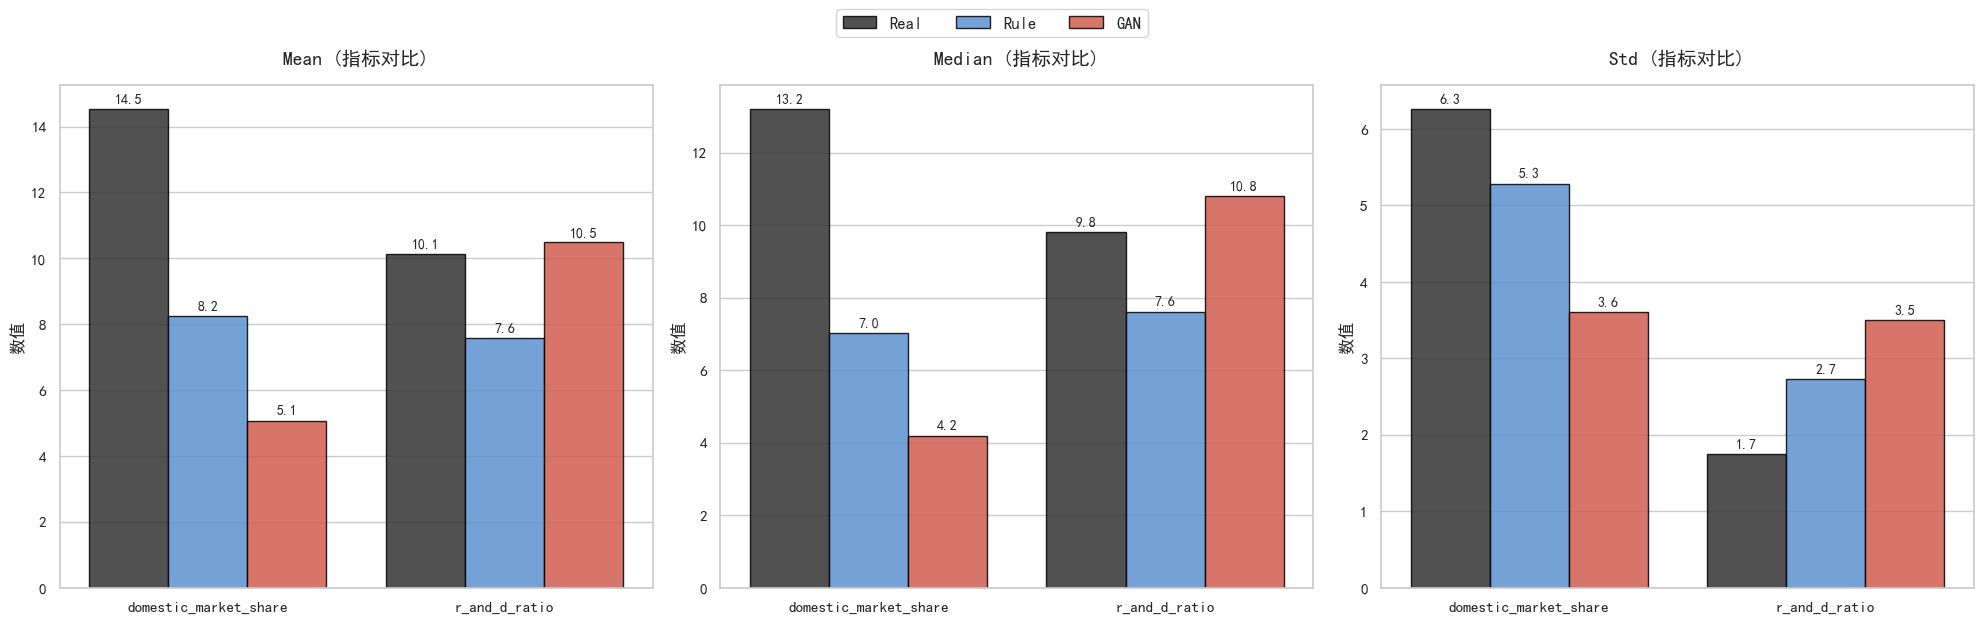

In [34]:

# === 2. 准备数据 ===
# 这里直接使用你提供的统计结果数据
# 实际使用中，你可以直接传入 evaluator.compare_statistics() 返回的 DataFrame
df_stats = re
# 2. 将其重命名为 'Feature' 以便后续代码读取
df_stats = df_stats.reset_index().rename(columns={'index': 'Feature'})

# 如果上面的 rename 没生效（有时 reset_index 后列名可能是 'level_0'），可以用这个通用防错写法：
if 'Feature' not in df_stats.columns:
    df_stats.columns.values[0] = 'Feature'
# === 3. 数据重塑 (Data Reshaping) ===
# 将“宽格式”数据转换为 Seaborn 喜欢的“长格式”
# 目标格式: Feature | Source | Metric | Value
rows = []
for idx, row in df_stats.iterrows():
    feature = row['Feature']
    for col in df_stats.columns:
        if col == 'Feature': continue
        
        # 解析列名，例如 "Real_Mean" -> Source="Real", Metric="Mean"
        parts = col.split('_')
        source = parts[0]  # Real, Rule, GAN
        metric = parts[1]  # Mean, Median, Std
        value = row[col]
        
        rows.append({
            "Feature": feature,
            "Source": source,
            "Metric": metric,
            "Value": value
        })

df_long = pd.DataFrame(rows)

# === 4. 绘图 ===
def plot_comparison(df_long):
    # 定义颜色映射，保持一致性 (黑/灰代表真实，蓝代表规则，红代表GAN)
    palette = {"Real": "#333333", "Rule": "#4A90E2", "GAN": "#E74C3C"}
    
    # 创建 1行3列 的子图
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
    
    metrics = ['Mean', 'Median', 'Std']
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # 筛选当前指标的数据
        subset = df_long[df_long['Metric'] == metric]
        
        # 绘制柱状图
        sns.barplot(
            data=subset, 
            x='Feature', 
            y='Value', 
            hue='Source', 
            palette=palette, 
            ax=ax,
            edgecolor="black", # 给柱子加个边框更清晰
            alpha=0.85
        )
        
        # 设置标题和标签
        ax.set_title(f"{metric} (指标对比)", fontsize=14, fontweight='bold', pad=15)
        ax.set_xlabel("")
        ax.set_ylabel("数值")
        
        # 在柱子上标注具体数值
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f', padding=3, fontsize=10)
            
        # 移除图例 (最后统一加一个总图例)
        ax.get_legend().remove()

    # 添加统一的图例
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=12)
    
    plt.tight_layout()
    plt.show()

# 运行绘图
plot_comparison(df_long)


=== 2. 正在绘制分布对比图... ===
图表已保存为: distribution_comparison.png


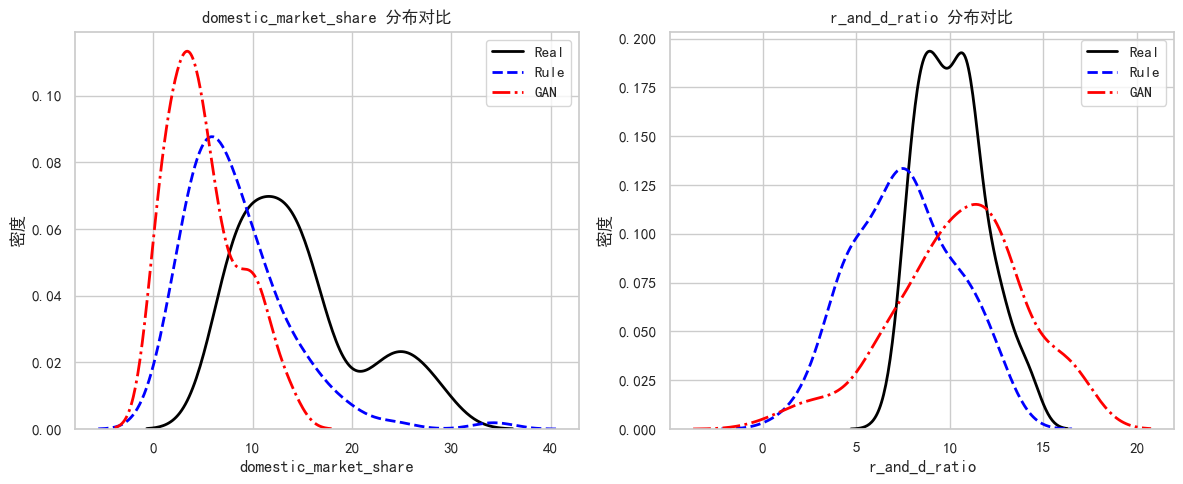

In [35]:
evaluator.plot_distributions()

In [36]:
results = evaluator.evaluate_utility()


=== 3. 机器学习效用对比 ===
任务目标: 基于其他特征预测 'r_and_d_ratio'
  [Real 模型] -> 真实测试集: MAE=0.37, R2=0.8222
  [Rule 模型] -> 真实测试集: MAE=2.50, R2=-3.0898
  [GAN 模型] -> 真实测试集: MAE=1.54, R2=-0.6051


In [37]:
evaluator.print_conclusion(results)


=== 4. 结论总结 ===
根据上述分析，得出以下结论：
✅ [优势] GAN 模型在捕捉数据间的非线性关系（机器学习效用）方面优于规则方法。
   GAN 训练的模型 R2 (-0.605) 高于 规则模型 (-3.090)，说明 GAN 更好地学习到了 'r_and_d_ratio' 的潜在规律。
ℹ️ [特点] 基于规则的方法通常在单字段的格式合规性上表现完美，但在多字段联合分布上往往比较僵硬。
   目前没有任何合成数据能完全达到真实数据的效果，这是正常的。
